<a href="https://colab.research.google.com/github/DipshikhaDas/Artificial-Intelligence-Project-3/blob/main/AIProject3(Sentiment_Analysis).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
from google.colab import drive
import os

mount_point = '/content/drive'

os.makedirs(mount_point, exist_ok=True)

drive.mount(mount_point)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
%cd /content/drive/My Drive/colab_content/ai_project_3
! ls

/content/drive/My Drive/colab_content/ai_project_3
a3_IMDb_Unseen_Reviews.csv  glove.6B.100d.txt  imdb_reviews_for_test.csv
c1_lstm_model_acc_0.857.h5  imdb_dataset.csv


In [12]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array

from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

In [13]:
movie_reviews = pd.read_csv("imdb_dataset.csv")

In [14]:
movie_reviews.shape

(50000, 2)

In [15]:
movie_reviews.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [16]:
movie_reviews.isnull().values.any()

False

<Axes: xlabel='sentiment', ylabel='count'>

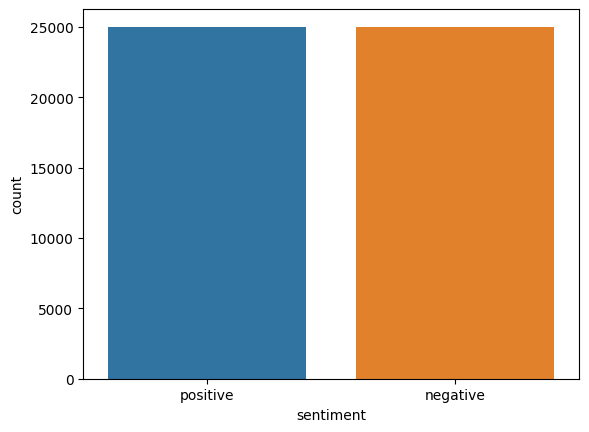

In [17]:
import seaborn as sns
sns.countplot(x='sentiment', data=movie_reviews)

In [18]:
movie_reviews["review"][2]

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [19]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [20]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [21]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''

    sentence = sen.lower()

    sentence = remove_tags(sentence)

    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    sentence = re.sub(r'\s+', ' ', sentence)

    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [22]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [23]:
X[10]

'phil alien one quirky films humour based around oddness everything rather actual punchlines first odd pretty funny movie progressed find jokes oddness funny anymore low budget film thats never problem pretty interesting characters eventually lost interest imagine film would appeal stoner currently partaking something similar better try brother another planet '

In [24]:
y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Embedding layer

In [26]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [27]:
vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

92394

In [28]:
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [29]:
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [30]:
embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [31]:
embedding_matrix.shape

(92394, 100)

# Start training model

## 1. Simple neural network

In [32]:
snn_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

snn_model.add(embedding_layer)

snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))

In [33]:
snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(snn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          9239400   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 1)                 10001     
                                                                 
Total params: 9249401 (35.28 MB)
Trainable params: 10001 (39.07 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None


In [34]:
snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 1s 4ms/step - loss: 0.5579 - acc: 0.7142 - val_loss: 0.5263 - val_acc: 0.7464
Epoch 2/6
250/250 [==============================] - 1s 3ms/step - loss: 0.4511 - acc: 0.7941 - val_loss: 0.4965 - val_acc: 0.7666
Epoch 3/6
250/250 [==============================] - 1s 3ms/step - loss: 0.4123 - acc: 0.8166 - val_loss: 0.4977 - val_acc: 0.7634
Epoch 4/6
250/250 [==============================] - 1s 3ms/step - loss: 0.3926 - acc: 0.8238 - val_loss: 0.5106 - val_acc: 0.7634
Epoch 5/6
250/250 [==============================] - 1s 3ms/step - loss: 0.3762 - acc: 0.8351 - val_loss: 0.5282 - val_acc: 0.7544
Epoch 6/6
250/250 [==============================] - 1s 3ms/step - loss: 0.3627 - acc: 0.8438 - val_loss: 0.5333 - val_acc: 0.7591


In [35]:
score = snn_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 0s 1ms/step - loss: 0.5601 - acc: 0.7454


In [36]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.560081422328949
Test Accuracy: 0.7454000115394592


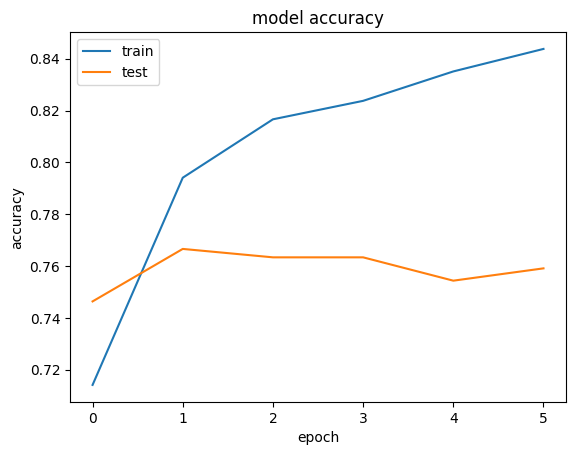

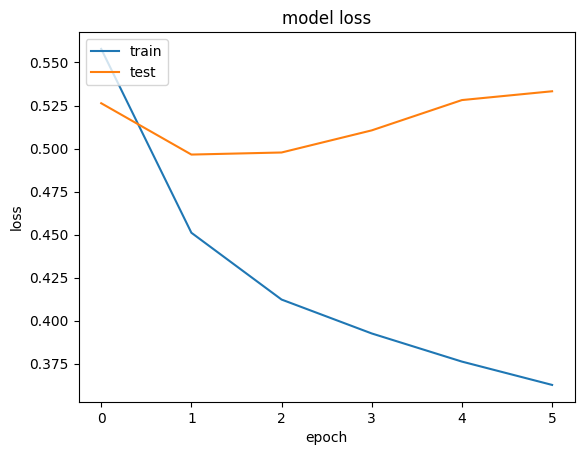

In [37]:
import matplotlib.pyplot as plt

plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Convolutional neural network(CNN)

In [38]:
cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [39]:
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9303657 (35.49 MB)
Trainable params: 64257 (251.00 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None


In [40]:
cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 16s 62ms/step - loss: 0.4641 - acc: 0.7803 - val_loss: 0.3897 - val_acc: 0.8264
Epoch 2/6
250/250 [==============================] - 16s 62ms/step - loss: 0.3384 - acc: 0.8545 - val_loss: 0.3665 - val_acc: 0.8376
Epoch 3/6
250/250 [==============================] - 14s 58ms/step - loss: 0.2902 - acc: 0.8832 - val_loss: 0.3430 - val_acc: 0.8493
Epoch 4/6
250/250 [==============================] - 15s 61ms/step - loss: 0.2406 - acc: 0.9085 - val_loss: 0.3292 - val_acc: 0.8561
Epoch 5/6
250/250 [==============================] - 15s 58ms/step - loss: 0.2025 - acc: 0.9302 - val_loss: 0.3281 - val_acc: 0.8561
Epoch 6/6
250/250 [==============================] - 15s 58ms/step - loss: 0.1693 - acc: 0.9485 - val_loss: 0.3301 - val_acc: 0.8569


In [41]:
score = cnn_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 2s 7ms/step - loss: 0.3341 - acc: 0.8537


In [42]:
print("Test Score:", score[0])
print("Test Score:", score[1])

Test Score: 0.3341418504714966
Test Score: 0.8536999821662903


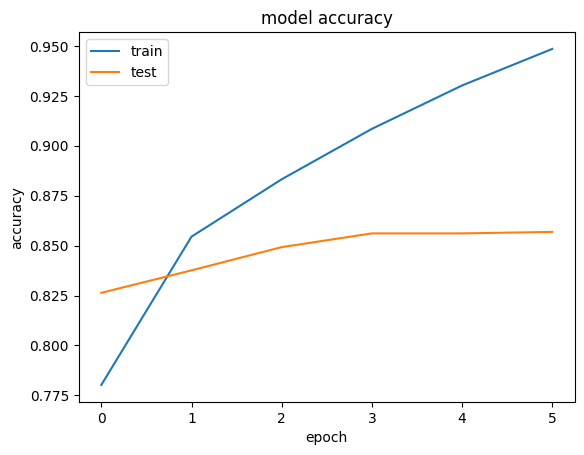

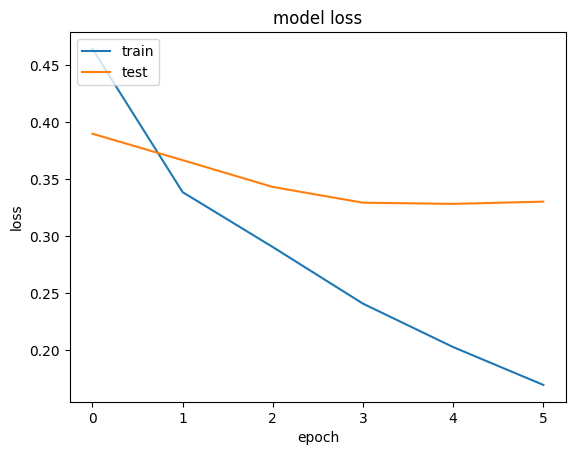

In [43]:
import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

## LSTM

In [44]:
from keras.layers import LSTM

In [45]:
lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))

In [46]:
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9356777 (35.69 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None


In [47]:
lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 58s 226ms/step - loss: 0.5747 - acc: 0.7096 - val_loss: 0.4675 - val_acc: 0.7910
Epoch 2/6
250/250 [==============================] - 57s 227ms/step - loss: 0.4507 - acc: 0.7990 - val_loss: 0.4328 - val_acc: 0.8008
Epoch 3/6
250/250 [==============================] - 53s 211ms/step - loss: 0.3953 - acc: 0.8258 - val_loss: 0.3640 - val_acc: 0.8386
Epoch 4/6
250/250 [==============================] - 51s 204ms/step - loss: 0.3634 - acc: 0.8424 - val_loss: 0.3644 - val_acc: 0.8450
Epoch 5/6
250/250 [==============================] - 56s 224ms/step - loss: 0.3308 - acc: 0.8598 - val_loss: 0.3298 - val_acc: 0.8577
Epoch 6/6
250/250 [==============================] - 56s 223ms/step - loss: 0.3158 - acc: 0.8683 - val_loss: 0.3150 - val_acc: 0.8669


In [48]:
score = lstm_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 11s 36ms/step - loss: 0.3197 - acc: 0.8662


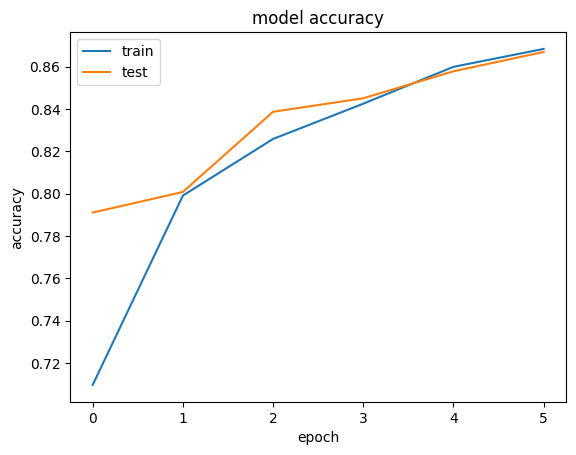

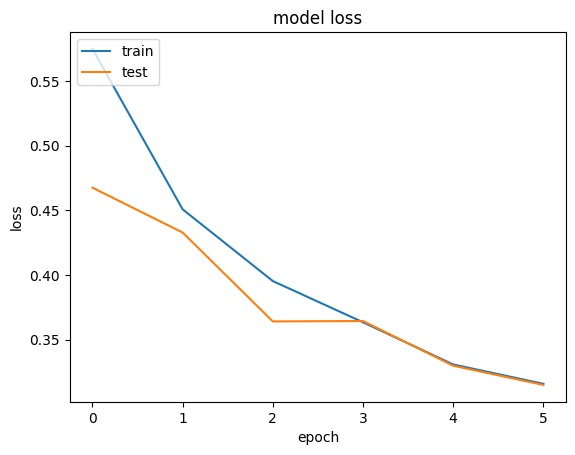

In [49]:
import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [50]:
lstm_model.save(f"./c1_lstm_model_acc_{round(score[1], 3)}.h5", save_format='h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [51]:
!ls

a3_IMDb_Unseen_Reviews.csv  c1_lstm_model_acc_0.866.h5	imdb_dataset.csv
c1_lstm_model_acc_0.857.h5  glove.6B.100d.txt		imdb_reviews_for_test.csv


In [52]:
!ls

a3_IMDb_Unseen_Reviews.csv  c1_lstm_model_acc_0.866.h5	imdb_dataset.csv
c1_lstm_model_acc_0.857.h5  glove.6B.100d.txt		imdb_reviews_for_test.csv


In [53]:
sample_reviews = pd.read_csv("a3_IMDb_Unseen_Reviews.csv")

sample_reviews.head(6)

,Unnamed: 0,Movie,Review Text,IMDb Rating
0,0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9
1,1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10
2,2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3
3,3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1
4,4,Eternals,Amazing visuals and philosophical concepts!\n\...,10
5,5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3


In [56]:
unseen_tokenized = word_tokenizer.texts_to_sequences(unseen_processed)

unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=maxlen)

In [57]:
unseen_reviews = sample_reviews['Review Text']

unseen_processed = []
for review in unseen_reviews:
  review = preprocess_text(review)
  unseen_processed.append(review)

In [58]:
unseen_sentiments = lstm_model.predict(unseen_padded)

unseen_sentiments

1/1 [==============================] - 0s 350ms/step


array([[0.86923385],
       [0.978688  ],
       [0.12437703],
       [0.6000338 ],
       [0.9551167 ],
       [0.00821977]], dtype=float32)

In [59]:
sample_reviews['Predicted Sentiments'] = np.round(unseen_sentiments*10,1)

df_prediction_sentiments = pd.DataFrame(sample_reviews['Predicted Sentiments'], columns = ['Predicted Sentiments'])
df_movie                 = pd.DataFrame(sample_reviews['Movie'], columns = ['Movie'])
df_review_text           = pd.DataFrame(sample_reviews['Review Text'], columns = ['Review Text'])
df_imdb_rating           = pd.DataFrame(sample_reviews['IMDb Rating'], columns = ['IMDb Rating'])


dfx=pd.concat([df_movie, df_review_text, df_imdb_rating, df_prediction_sentiments], axis=1)

dfx.to_csv("./c2_IMDb_Unseen_Predictions.csv", sep=',', encoding='UTF-8')

dfx.head(6)

,Movie,Review Text,IMDb Rating,Predicted Sentiments
0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9,8.7
1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10,9.8
2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3,1.2
3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1,6.0
4,Eternals,Amazing visuals and philosophical concepts!\n\...,10,9.6
5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3,0.1
